# Revised Magnitude tests (With larger models)
What exactly does magnitude correlate in word embeddings from Large Language Models? Can we find markers of complexity in differences between clearly defined groups of English language words?

I will compare dialects (British-English, American-English), plurals (wife, wives), and Oxford Corpus frequencies as a part of attempting to investigate these issues.

In [1]:
import os
import torch
import openai
import random
import numpy as np

import sentencepiece    # necessary for proper t5 init.
from transformers import T5Tokenizer, T5EncoderModel, GPT2Tokenizer, OPTModel

from sklearn.metrics.pairwise import cosine_similarity

# api key set in conda env.
openai.api_key = os.getenv('OPENAI_API_KEY')

## Load Models

### Vocab

In [2]:
vocab = []
with open('./vocab/expanded_vocab.txt', 'r') as f:
    for line in f:
        vocab.append(line.strip())

len(vocab)

5124

In [3]:
top_50 = []
with open('./vocab/top_50.txt', 'r') as f:
    for line in f:
        top_50.append(line.strip())

bottom_50 = []
with open('./vocab/bottom_50.txt', 'r') as f:
    for line in f:
        bottom_50.append(line.strip())

### OPT-1.3b

In [4]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('facebook/opt-13b', cache_dir='/scratch/mbarlow6/.cache')
model_opt_raw = OPTModel.from_pretrained('facebook/opt-13b', cache_dir='/scratch/mbarlow6/.cache')

Some weights of the model checkpoint at facebook/opt-13b were not used when initializing OPTModel: ['decoder.final_layer_norm.weight', 'decoder.final_layer_norm.bias']
- This IS expected if you are initializing OPTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing OPTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
opt_embeds = []
with open(u'./opt/13B.txt', 'r') as f:
    for line in f:
        opt_embeds.append([float(x) for x in line.strip().split()])
model_opt = dict(zip(vocab, opt_embeds))

In [6]:
def opt_embed(text, tokenizer=gpt2_tokenizer, model=model_opt_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings[1:], dim=0))

### T5

In [7]:
t5_tokenizer = T5Tokenizer.from_pretrained('t5-3b', cache_dir='/scratch/mbarlow6/.cache')
model_t5_raw = T5EncoderModel.from_pretrained('t5-3b', cache_dir='/scratch/mbarlow6/.cache')

/home/mbarlow6/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-3b automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(
Some weights of the model checkpoint at t5-3b were not used when initializing T5EncoderModel: ['decoder.block.17.layer.1.EncDecAttention.k.weight', 'decoder.block.10.layer.2.DenseReluDense.wo.weight', 'decoder.block.16.layer.0.SelfAttention

In [8]:
t5_embeds = []
with open('./t5/t53b.txt', 'r') as f:
    for line in f:
        t5_embeds.append([float(x) for x in line.strip().split()])
model_t5 = dict(zip(vocab, t5_embeds))

In [9]:
def t5_embed(text, tokenizer=t5_tokenizer, model=model_t5_raw, debug=False):
    inputs = tokenizer(text, return_tensors='pt')
    if debug:
        print('Tokens Requested:')
        print(tokenizer.batch_decode(inputs.input_ids[0]))
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = torch.squeeze(outputs.last_hidden_state, dim=0)
    return np.array(torch.mean(embeddings, dim=0))

## Helper Functions

In [10]:
def positive(words, model='opt'):
    """
    Args:
        words: iterable
        model: 'opt' or 't5'
    Returns:
        Positive (summed vectors) of word embeddings of a given list of words from the specified model. Defaults to OPT-1.3b.
    """
    if isinstance(words, str):
        print(f"You requested the positive of the string \"{words}\". Did you mean [\"{words}\"]?")

    out = 0
    for token in words:
        word = str(token)
        if model.lower() == 'opt':
            if word in model_opt:
                ex = model_opt[word]
            else:
                ex = opt_embed(word)
                model_opt[word] = ex
        elif model.lower() == 't5':
            if word in model_t5:
                ex = model_t5[word]
            else:
                ex = t5_embed(word)
                model_t5[word] = ex
        else:
            raise ValueError('Please provide either opt or t5 as a model choice.')

        # construct positive
        if isinstance(out, int):
            out = np.array(ex).reshape(1, -1)
        else:
            out += np.array(ex).reshape(1, -1)
            
    return out if not isinstance(out, int) else np.array([])

In [11]:
def sum_complexity(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the sum of the absolute value of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [abs(float(x)) for x in phrase[0]]
    return sum(modified)
    

In [12]:
def simple_sum(word, vec=False, model='opt'):
    """
    Args:
        word: iterable, string, or vector   -> embedding to be summed.
        vec: bool                           -> True if word is already vector.
        model: str                          -> 'opt' or 't5'
    Returns:
        Float score of the simple sum of each datapoint in the embedding.
    """
    phrase = word
    if not vec:
        if isinstance(word, str):
            phrase = positive([word], model=model)
        else:
            phrase = positive(word, model=model)
    
    modified = [float(x) for x in phrase[0]]
    return sum(modified)

In [13]:
def similar_dims(w1, w2, n=10):
    # performs dimension-wise comparison of two vectors of EQUAL size
    # returns the top and bottom n scores.
    sims = []
    for i in range(w1.shape[1]):
        x = w1[0][i]
        y = w2[0][i]
        sims.append((i, (x, y), abs(x-y)))
    sims.sort(key=lambda x: x[2])
    return sims[:n], sims[len(sims)-n:]

In [14]:
def sig_dim(word, topn=5, model='opt'):
    """
    Args:
        word: str   target word to evaluate
        topn: int   number of dimesions to return
        model: str  'opt' or 't5'. Defaults to 'opt'.
    Returns:
        Indices of the n largest dimensions in the vector embedding of word in model.
    """
    p = positive([word], model=model)
    helper = []
    for i in range(len(p[0])):
        helper.append((i, p[0][i]))
    helper.sort(key=lambda x: abs(x[1]), reverse=True)
    return helper[:topn]

In [15]:
def percent_diff(word1, word2, model='opt'):
    w1c = sum_complexity(word1, model=model)
    w2c = sum_complexity(word2, model=model)

    return (w1c, w2c, ((w1c / w2c) - 1) * 100)

In [16]:
# @cache
def avg_diff(n, word1=None, corpus=top_50, model='opt'):
    if n > len(corpus):
        n = len(corpus)
    srcwords = [word1] * n if not word1 is None else random.sample(corpus, k=n)
    destwords = random.sample(corpus, k=n)

    history = []
    sm = 0

    for word1 in srcwords:
        for word2 in destwords:
            if word1 == word2:
                continue
            ans = percent_diff(word1, word2, model)
            history.append(ans)
            sm += ans[2]
            
    history.sort(key=lambda x: abs(x[2]), reverse=True)
    av = sm / (n ** 2)
    return av, history
    

In [15]:
def compare_mag(words):
    """
    Wrapper for direct comparison using our magnitude tests
    """
    if isinstance(words, str):
        words = [words] 
    for word in words:
        print(word)
        print(f"\t\tOPT\t\t\tT5")
        print(f"Simple Sum:\t{simple_sum(word)}\t{simple_sum(word, model='t5')}")
        print(f"Absolute Sum:\t{sum_complexity(word)}\t{sum_complexity(word, model='t5')}")
        print(f"Signif. Dims:\tOPT: {sig_dim(word)}\n\t\tT5:  {sig_dim(word, model='t5')}")
        print('--------------------------------------------------------------\n')
        

In [56]:
def compare_mag(words, n=100):
    if isinstance(words, str):
        words = [words] 
    print("Word pair\t\tOPT\t\tT5")
    for i in range(len(words)-1):
        w1 = words[i]
        for j in range(i+1, len(words)):
            w2 = words[j]
            comp_opt = percent_diff(w1, w2)
            comp_t5 = percent_diff(w1, w2, model='t5')
            print(f"{w1} -> {w2}\t\t{'{:.4f}'.format(comp_opt[2])}%\t\t{'{:.4f}'.format(comp_t5[2])}%")
    print()
    for word in words:
        rand100_t5, _ = avg_diff(n, corpus=vocab, word1=word, model='t5')
        rand100_opt, _ = avg_diff(n, corpus=vocab, word1=word)

        t50_t5, _ = avg_diff(50, corpus=top_50, word1=word, model='t5')
        t50_opt, _ = avg_diff(50, corpus=top_50, word1=word)

        b50_t5, _ = avg_diff(50, corpus=bottom_50, word1=word, model='t5')
        b50_opt, _ = avg_diff(50, corpus=bottom_50, word1=word)

        print(f"{word} -> B50\t\t{'{:.4f}'.format(b50_opt)}%\t\t{'{:.4f}'.format(b50_t5)}%")
        print(f"{word} -> T50\t\t{'{:.4f}'.format(t50_opt)}%\t\t{'{:.4f}'.format(t50_t5)}%")
        print(f"{word} -> Rand100\t{'{:.4f}'.format(rand100_opt)}%\t\t{'{:.4f}'.format(rand100_t5)}%")
        print()
        

## Run Tests

In plain english, the below tests explain relations like "The magnitude of 'color' is 16% larger than 'colour' in OPT-1.3B."

When the relationship is "word -> {vocab}", we are saying "The magnitude of 'color' is on average 4.8% smaller than the magnitude of a word in the {bottom 50 words by usage in English} in T5."

Rand100 is a random sampling of 100 words (and their magnitudes) from our 5124 word large vocabulary.

### American -> British English

In [57]:
compare_mag(['color', 'colour'])

Word pair		OPT		T5
color -> colour		16.6391%		-12.3476%

color -> B50		9.1763%		-4.8143%
color -> T50		9.0847%		20.4181%
color -> Rand100	0.9452%		-7.3221%

colour -> B50		-6.3982%		8.5945%
colour -> T50		-6.4767%		37.3814%
colour -> Rand100	-12.6015%		9.6403%



In [58]:
compare_mag(['flavor', 'flavour'])

Word pair		OPT		T5
flavor -> flavour		1.6610%		2.7803%

flavor -> B50		6.3578%		22.6129%
flavor -> T50		6.2685%		55.1159%
flavor -> Rand100	-2.6118%		18.5482%

flavour -> B50		4.6200%		19.2962%
flavour -> T50		4.5322%		50.9200%
flavour -> Rand100	-4.6717%		17.6763%



In [59]:
compare_mag(['apologize', 'apologise'])

Word pair		OPT		T5
apologize -> apologise		7.8484%		45.8314%

apologize -> B50		32.1745%		8.0277%
apologize -> T50		32.0636%		36.6644%
apologize -> Rand100	23.6453%		5.2447%

apologise -> B50		22.5559%		-25.9228%
apologise -> T50		22.4530%		-6.2860%
apologise -> Rand100	14.0199%		-26.4394%



In [60]:
compare_mag(['organize', 'organise'])

Word pair		OPT		T5
organize -> organise		-3.6187%		24.0656%

organize -> B50		21.8052%		3.6328%
organize -> T50		21.7030%		31.1045%
organize -> Rand100	12.0849%		1.6955%

organise -> B50		26.3784%		-16.4693%
organise -> T50		26.2723%		5.6735%
organise -> Rand100	17.0366%		-17.2163%



In [61]:
compare_mag(['analyze', 'analyse'])

Word pair		OPT		T5
analyze -> analyse		15.1123%		-6.7823%

analyze -> B50		15.9648%		9.9179%
analyze -> T50		15.8675%		39.0556%
analyze -> Rand100	6.9369%		8.9379%

analyse -> B50		0.7406%		17.9152%
analyse -> T50		0.6560%		49.1730%
analyse -> Rand100	-6.6361%		14.8235%



In [62]:
compare_mag(['traveled', 'travelled'])

Word pair		OPT		T5
traveled -> travelled		4.6694%		31.5404%

traveled -> B50		39.2893%		10.0387%
traveled -> T50		39.1724%		39.2085%
traveled -> Rand100	30.0446%		9.2955%

travelled -> B50		33.0755%		-16.3461%
travelled -> T50		32.9638%		5.8294%
travelled -> Rand100	22.7489%		-19.2470%



In [63]:
compare_mag(['maneuver', 'manoeuvre'])

Word pair		OPT		T5
maneuver -> manoeuvre		-5.5757%		-4.7631%

maneuver -> B50		6.2024%		11.2966%
maneuver -> T50		6.1133%		40.7998%
maneuver -> Rand100	-2.2226%		8.9944%

manoeuvre -> B50		12.4736%		16.8629%
manoeuvre -> T50		12.3792%		47.8417%
manoeuvre -> Rand100	2.7776%		14.4068%



In [64]:
compare_mag(['pediatric', 'paediatric'])

Word pair		OPT		T5
pediatric -> paediatric		-4.0085%		-2.5265%

pediatric -> B50		6.6580%		11.6440%
pediatric -> T50		6.5685%		41.2393%
pediatric -> Rand100	-1.1209%		11.5085%

paediatric -> B50		11.1119%		14.5378%
paediatric -> T50		11.0187%		44.9002%
paediatric -> Rand100	2.2222%		14.2209%



In [65]:
compare_mag(['license', 'licence'])

Word pair		OPT		T5
license -> licence		6.6653%		-1.2072%

license -> B50		3.0114%		4.7900%
license -> T50		2.9249%		32.5684%
license -> Rand100	-7.2433%		1.6943%

licence -> B50		-3.4256%		6.0705%
licence -> T50		-3.5067%		34.1883%
licence -> Rand100	-9.2261%		2.5531%



In [66]:
compare_mag(['offence', 'offense'])

Word pair		OPT		T5
offence -> offense		-6.2777%		-0.8820%

offence -> B50		11.7054%		-3.5937%
offence -> T50		11.6117%		21.9623%
offence -> Rand100	4.1027%		-4.8102%

offense -> B50		19.1876%		-2.7358%
offense -> T50		19.0876%		23.0477%
offense -> Rand100	9.5467%		-5.8649%



In [67]:
compare_mag(['analog', 'analogue'])

Word pair		OPT		T5
analog -> analogue		1.2091%		0.0304%

analog -> B50		-4.3193%		9.4056%
analog -> T50		-4.3996%		38.4075%
analog -> Rand100	-11.6220%		4.5846%

analogue -> B50		-5.4624%		9.3724%
analogue -> T50		-5.5417%		38.3655%
analogue -> Rand100	-12.8455%		6.4991%



### Simple plurals

In [68]:
compare_mag(['wife', 'wives'])

Word pair		OPT		T5
wife -> wives		-11.6042%		5.2107%

wife -> B50		4.3256%		-3.8239%
wife -> T50		4.2380%		21.6711%
wife -> Rand100	-3.4886%		-4.1665%

wives -> B50		18.0210%		-8.5872%
wives -> T50		17.9220%		15.6452%
wives -> Rand100	10.0721%		-9.4576%



In [69]:
compare_mag(['dog', 'dogs'])

Word pair		OPT		T5
dog -> dogs		-9.4832%		-6.3314%

dog -> B50		2.4516%		1.5851%
dog -> T50		2.3656%		28.5140%
dog -> Rand100	-5.9159%		-0.6041%

dogs -> B50		13.1851%		8.4516%
dogs -> T50		13.0901%		37.2007%
dogs -> Rand100	4.8376%		6.2334%



In [70]:
compare_mag(['tooth', 'teeth'])

Word pair		OPT		T5
tooth -> teeth		1.3954%		3.3916%

tooth -> B50		16.1328%		8.3603%
tooth -> T50		16.0353%		37.0852%
tooth -> Rand100	7.3075%		7.8942%

teeth -> B50		14.5346%		4.8058%
teeth -> T50		14.4385%		32.5884%
teeth -> Rand100	5.5230%		1.1510%



In [71]:
compare_mag(['man', 'men'])

Word pair		OPT		T5
man -> men		-5.9612%		15.0742%

man -> B50		-10.4811%		1.1225%
man -> T50		-10.5562%		27.9287%
man -> Rand100	-18.4360%		-2.4926%

men -> B50		-4.8064%		-12.1241%
men -> T50		-4.8863%		11.1707%
men -> Rand100	-10.3916%		-12.8909%



In [72]:
compare_mag(['potato', 'potatoes'])

Word pair		OPT		T5
potato -> potatoes		-8.6464%		0.3022%

potato -> B50		9.6363%		7.3476%
potato -> T50		9.5442%		35.8040%
potato -> Rand100	0.2746%		5.2727%

potatoes -> B50		20.0131%		7.0242%
potatoes -> T50		19.9124%		35.3949%
potatoes -> Rand100	11.9541%		3.1603%



In [73]:
compare_mag(['mouse', 'mice'])

Word pair		OPT		T5
mouse -> mice		-0.1047%		-3.7454%

mouse -> B50		3.9847%		3.2942%
mouse -> T50		3.8974%		30.6762%
mouse -> Rand100	-4.2518%		1.1988%

mice -> B50		4.0937%		7.3136%
mice -> T50		4.0063%		35.7609%
mice -> Rand100	-3.7953%		5.5301%



In [74]:
compare_mag(['child', 'children'])

Word pair		OPT		T5
child -> children		-1.5753%		15.9344%

child -> B50		8.6987%		-5.2516%
child -> T50		8.6075%		19.8649%
child -> Rand100	0.7603%		-7.1813%

children -> B50		10.4385%		-18.2741%
children -> T50		10.3458%		3.3904%
children -> Rand100	2.3767%		-20.3131%



In [75]:
compare_mag(['person', 'persons', 'people'])

Word pair		OPT		T5
person -> persons		-15.9727%		-37.5236%
person -> people		-9.0866%		14.9036%
persons -> people		8.1950%		83.9153%

person -> B50		0.5509%		-26.2576%
person -> T50		0.4665%		-6.7095%
person -> Rand100	-7.5496%		-28.1707%

persons -> B50		19.6645%		18.0325%
persons -> T50		19.5641%		49.3213%
persons -> Rand100	10.4810%		17.5231%

people -> B50		10.6008%		-35.8224%
people -> T50		10.5080%		-18.8097%
people -> Rand100	4.8594%		-38.0081%



In [76]:
compare_mag(['radius', 'radii'])

Word pair		OPT		T5
radius -> radii		6.6568%		27.3393%

radius -> B50		-1.0339%		17.3079%
radius -> T50		-1.1170%		48.4047%
radius -> Rand100	-8.5891%		14.1502%

radii -> B50		-7.2107%		-7.8776%
radii -> T50		-7.2886%		16.5428%
radii -> Rand100	-14.6577%		-10.5285%



In [77]:
compare_mag(['nucleus', 'nuclei'])

Word pair		OPT		T5
nucleus -> nuclei		-15.9624%		2.3786%

nucleus -> B50		-11.6955%		26.5414%
nucleus -> T50		-11.7697%		60.0858%
nucleus -> Rand100	-18.2316%		21.8223%

nuclei -> B50		5.0773%		23.6014%
nuclei -> T50		4.9891%		56.3665%
nuclei -> Rand100	-4.1010%		20.7775%



In [78]:
compare_mag(['alumna', 'alumnae', 'alumnus', 'alumni'])

Word pair		OPT		T5
alumna -> alumnae		-13.8136%		-6.3729%
alumna -> alumnus		-11.6663%		-2.9988%
alumna -> alumni		-1.5922%		-26.6702%
alumnae -> alumnus		2.4914%		3.6037%
alumnae -> alumni		14.1801%		-21.6789%
alumnus -> alumni		11.4046%		-24.4032%

alumna -> B50		7.6035%		-19.8632%
alumna -> T50		7.5132%		1.3800%
alumna -> Rand100	-0.7782%		-21.7888%

alumnae -> B50		24.8497%		-14.4086%
alumnae -> T50		24.7449%		8.2805%
alumnae -> Rand100	16.0256%		-17.1272%

alumnus -> B50		21.8148%		-17.3858%
alumnus -> T50		21.7125%		4.5142%
alumnus -> Rand100	11.2905%		-16.9833%

alumni -> B50		9.3445%		9.2827%
alumni -> T50		9.2527%		38.2521%
alumni -> Rand100	2.4283%		7.8080%



In [79]:
compare_mag(['crisis', 'crises'])

Word pair		OPT		T5
crisis -> crises		-17.2510%		34.9170%

crisis -> B50		-1.7281%		-0.2465%
crisis -> T50		-1.8106%		26.1968%
crisis -> Rand100	-8.6794%		-4.2441%

crises -> B50		18.7590%		-26.0631%
crises -> T50		18.6593%		-6.4634%
crises -> Rand100	9.5111%		-28.7731%



In [80]:
compare_mag(['thesis', 'theses'])

Word pair		OPT		T5
thesis -> theses		-19.9102%		11.0055%

thesis -> B50		-11.7779%		13.8132%
thesis -> T50		-11.8519%		43.9835%
thesis -> Rand100	-20.2284%		10.5795%

theses -> B50		10.1540%		2.5293%
theses -> T50		10.0616%		29.7084%
theses -> Rand100	0.0779%		0.8124%



In [81]:
compare_mag(['phenomenon', 'phenomena'])

Word pair		OPT		T5
phenomenon -> phenomena		4.9327%		-3.7212%

phenomenon -> B50		30.1773%		17.3070%
phenomenon -> T50		30.0681%		48.4036%
phenomenon -> Rand100	20.9155%		16.7166%

phenomena -> B50		24.0579%		21.8410%
phenomena -> T50		23.9538%		54.1394%
phenomena -> Rand100	13.1154%		20.2016%



In [82]:
compare_mag(['datum', 'data'])

Word pair		OPT		T5
datum -> data		-18.5910%		35.1565%

datum -> B50		-14.6452%		19.1637%
datum -> T50		-14.7169%		50.7524%
datum -> Rand100	-20.4086%		17.9623%

data -> B50		4.8468%		-11.8328%
data -> T50		4.7588%		11.5392%
data -> Rand100	-2.3614%		-13.1971%



In [83]:
compare_mag(['bacterium', 'bacteria'])

Word pair		OPT		T5
bacterium -> bacteria		-1.5066%		-14.0333%

bacterium -> B50		15.4655%		-9.1887%
bacterium -> T50		15.3686%		14.8842%
bacterium -> Rand100	7.2346%		-8.1227%

bacteria -> B50		17.2317%		5.6354%
bacteria -> T50		17.1333%		33.6380%
bacteria -> Rand100	8.9417%		4.0204%



In [84]:
compare_mag(['index', 'indicies'])

Word pair		OPT		T5
index -> indicies		-14.6523%		0.4810%

index -> B50		1.0987%		17.4035%
index -> T50		1.0139%		48.5256%
index -> Rand100	-5.4031%		14.8035%

indicies -> B50		18.4551%		16.8415%
indicies -> T50		18.3557%		47.8146%
indicies -> Rand100	8.9861%		17.0044%



In [85]:
compare_mag(['appendix', 'appendices', 'appendixes'])

Word pair		OPT		T5
appendix -> appendices		-17.1867%		42.3187%
appendix -> appendixes		-21.4966%		48.2792%
appendices -> appendixes		-5.2044%		4.1882%

appendix -> B50		0.4754%		16.2335%
appendix -> T50		0.3910%		47.0454%
appendix -> Rand100	-7.9142%		11.9530%

appendices -> B50		21.3276%		-18.3287%
appendices -> T50		21.2258%		3.3212%
appendices -> Rand100	11.2749%		-20.4442%

appendixes -> B50		27.9886%		-21.6118%
appendixes -> T50		27.8812%		-0.8321%
appendixes -> Rand100	18.9531%		-23.4757%



### Verb Forms

In [86]:
compare_mag(['chew', 'chews', 'chewing', 'chewed'])

Word pair		OPT		T5
chew -> chews		-5.6314%		14.2757%
chew -> chewing		-4.7012%		13.3061%
chew -> chewed		-3.7674%		18.0497%
chews -> chewing		0.9857%		-0.8485%
chews -> chewed		1.9752%		3.3025%
chewing -> chewed		0.9799%		4.1865%

chew -> B50		12.3076%		9.5266%
chew -> T50		12.2133%		38.5607%
chew -> Rand100	4.6677%		6.9328%

chews -> B50		19.0095%		-4.1558%
chews -> T50		18.9096%		21.2512%
chews -> Rand100	11.3942%		-3.4706%

chewing -> B50		17.8478%		-3.3357%
chewing -> T50		17.7489%		22.2888%
chewing -> Rand100	8.5010%		-5.9251%

chewed -> B50		16.7043%		-7.2199%
chewed -> T50		16.6063%		17.3748%
chewed -> Rand100	9.2240%		-9.0279%



In [87]:
compare_mag(['talk', 'talks', 'talkling', 'talked'])

Word pair		OPT		T5
talk -> talks		-7.1222%		-12.6837%
talk -> talkling		8.1735%		-2.8381%
talk -> talked		-26.9530%		-11.0032%
talks -> talkling		16.4686%		11.2758%
talks -> talked		-21.3514%		1.9246%
talkling -> talked		-32.4723%		-8.4036%

talk -> B50		5.5459%		-1.4059%
talk -> T50		5.4573%		24.7301%
talk -> Rand100	-0.0873%		-5.9597%

talks -> B50		13.6395%		12.9161%
talks -> T50		13.5441%		42.8486%
talks -> Rand100	7.1273%		12.3197%

talkling -> B50		-2.4291%		1.4741%
talkling -> T50		-2.5110%		28.3735%
talkling -> Rand100	-9.7423%		-0.8692%

talked -> B50		44.4903%		10.7840%
talked -> T50		44.3690%		40.1513%
talked -> Rand100	33.0326%		6.5315%



In [88]:
compare_mag(['run', 'runs', 'running', 'ran'])

Word pair		OPT		T5
run -> runs		-15.7964%		-9.4997%
run -> running		-18.8789%		-3.3751%
run -> ran		-11.9698%		1.2938%
runs -> running		-3.6607%		6.7674%
runs -> ran		4.5445%		11.9265%
running -> ran		8.5170%		4.8320%

run -> B50		-15.4102%		-14.7582%
run -> T50		-15.4812%		7.8383%
run -> Rand100	-22.2135%		-17.9174%

runs -> B50		0.4587%		-5.8105%
runs -> T50		0.3744%		19.1579%
runs -> Rand100	-6.2559%		-7.5860%

running -> B50		4.2759%		-11.7807%
running -> T50		4.1884%		11.6051%
running -> Rand100	-3.9372%		-9.7153%

ran -> B50		-3.9082%		-15.8470%
ran -> T50		-3.9889%		6.4609%
ran -> Rand100	-10.4842%		-18.8437%



In [89]:
compare_mag(['think', 'thinks', 'thinking', 'thought'])

Word pair		OPT		T5
think -> thinks		-29.0104%		-29.1391%
think -> thinking		-10.9852%		-30.5238%
think -> thought		-5.6003%		-10.5355%
thinks -> thinking		25.3915%		-1.9541%
thinks -> thought		32.9769%		26.2537%
thinking -> thought		6.0494%		28.7700%

think -> B50		3.7504%		-29.2189%
think -> T50		3.6633%		-10.4558%
think -> Rand100	-2.8351%		-31.0113%

thinks -> B50		46.1488%		-0.1126%
thinks -> T50		46.0261%		26.3662%
thinks -> Rand100	30.8906%		0.7964%

thinking -> B50		16.5540%		1.8782%
thinking -> T50		16.4562%		28.8847%
thinking -> Rand100	8.3121%		-0.6889%

thought -> B50		9.9054%		-20.8836%
thought -> T50		9.8131%		0.0891%
thought -> Rand100	3.3150%		-22.8273%



In [90]:
compare_mag(['drive', 'drives', 'driving', 'drove'])

Word pair		OPT		T5
drive -> drives		-18.5610%		-4.2835%
drive -> driving		-11.8191%		-11.2947%
drive -> drove		-21.2987%		-9.1208%
drives -> driving		8.2784%		-7.3250%
drives -> drove		-3.3617%		-5.0538%
driving -> drove		-10.7501%		2.4507%

drive -> B50		0.2382%		-3.0878%
drive -> T50		0.1540%		22.6024%
drive -> Rand100	-7.0658%		-5.6272%

drives -> B50		23.0837%		1.2492%
drives -> T50		22.9804%		28.0890%
drives -> Rand100	15.9555%		-1.2354%

driving -> B50		13.6734%		9.2519%
driving -> T50		13.5780%		38.2131%
driving -> Rand100	7.7687%		8.7894%

drove -> B50		27.3653%		6.6386%
drove -> T50		27.2584%		34.9070%
drove -> Rand100	16.2882%		2.2859%



In [91]:
compare_mag(['cry', 'cries', 'crying', 'cried'])

Word pair		OPT		T5
cry -> cries		4.2413%		-6.2338%
cry -> crying		13.0175%		-5.8324%
cry -> cried		7.2742%		4.0858%
cries -> crying		8.4191%		0.4280%
cries -> cried		2.9095%		11.0057%
crying -> cried		-5.0818%		10.5326%

cry -> B50		29.2045%		-8.4745%
cry -> T50		29.0961%		15.7877%
cry -> Rand100	21.7876%		-10.7720%

cries -> B50		23.9475%		-2.3897%
cries -> T50		23.8435%		23.4854%
cries -> Rand100	14.7632%		-2.5531%

crying -> B50		14.3226%		-2.8057%
crying -> T50		14.2266%		22.9592%
crying -> Rand100	6.2669%		-4.7996%

cried -> B50		20.4432%		-12.0673%
cried -> T50		20.3422%		11.2425%
cried -> Rand100	11.8331%		-15.2685%



### Top 50, Bottom 50

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

In [17]:
X = bottom_50 + top_50
Y_opt = [sum_complexity(p) for p in X]
Y_t5 = [sum_complexity(p, model='t5') for p in X]
# red for bottom 50, blue for top
colors = ['r' if x < 50 else 'b' for x in range(100)]

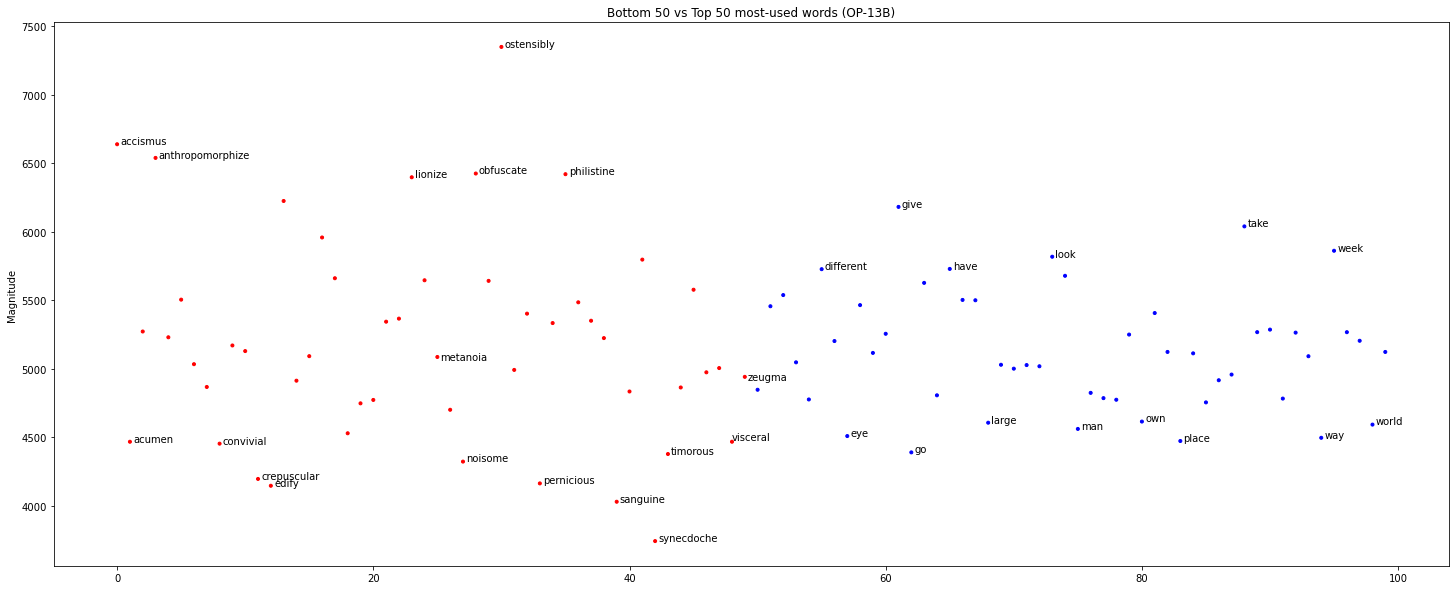

In [18]:
plt.figure(figsize=(25, 10))
plt.title('Bottom 50 vs Top 50 most-used words (OP-13B)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_opt, c=colors, marker='.')
for i in range(0, 100):
    if i < 48:
        if i == 25:
            plt.annotate(X[i], (i+0.25, Y_opt[i]-20))
        elif Y_opt[i] > 6250:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] < 4500:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
    elif i == 48:
        plt.annotate(X[i], (i, Y_opt[i]+15))
    elif i == 49:
        plt.annotate(X[i], (i+0.25, Y_opt[i]-25))
    else:
        if Y_opt[i] < 4750:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))
        elif Y_opt[i] > 5700:
            plt.annotate(X[i], (i+0.25, Y_opt[i]+1))


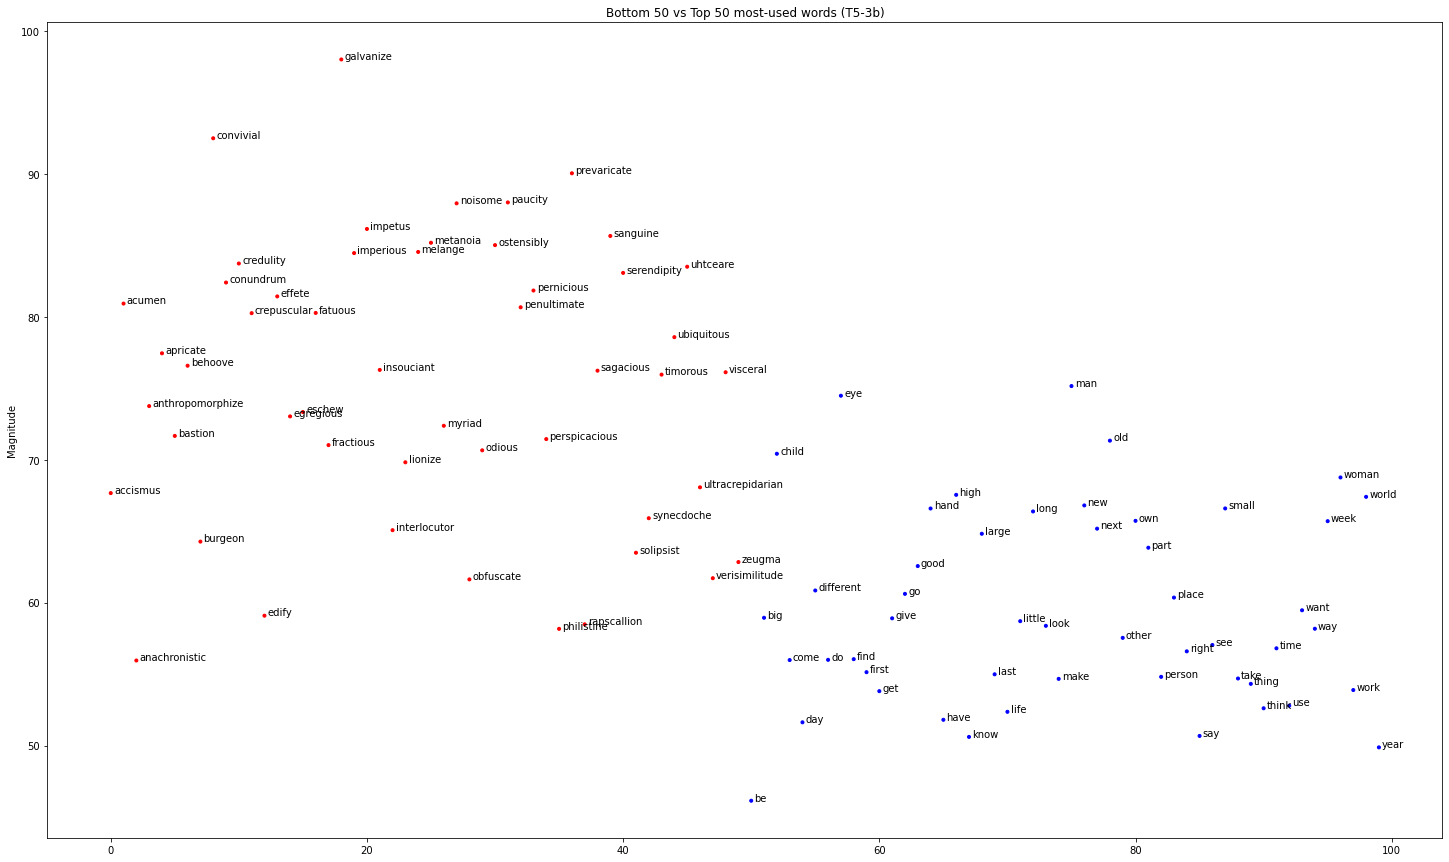

In [48]:
plt.figure(figsize=(25, 15))
plt.title('Bottom 50 vs Top 50 most-used words (T5-3b)')
plt.ylabel('Magnitude')
plt.scatter(range(100), Y_t5, c=colors, marker='.')
for i in range(0, 100):
    plt.annotate(X[i], (i+0.25, Y_t5[i]))

* Revisions

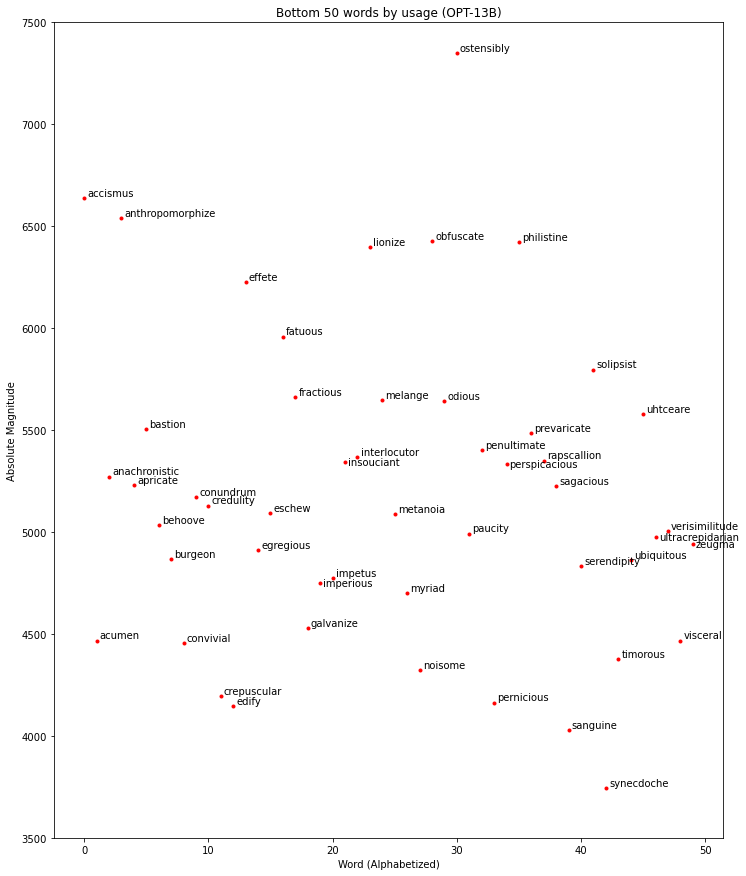

In [58]:
plt.figure(figsize=(12, 15))
plt.title('Bottom 50 words by usage (OPT-13B)')
plt.ylabel('Absolute Magnitude')
plt.ylim((3500, 7500))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_opt[:50], c='r', marker='.')

# add labels
for i in range(50):
    if i in [19, 21, 34, 46, 49]:
        plt.annotate(X[i], (i+0.25, Y_opt[i]-15))
    else:    
        plt.annotate(X[i], (i+0.25, Y_opt[i]+10))

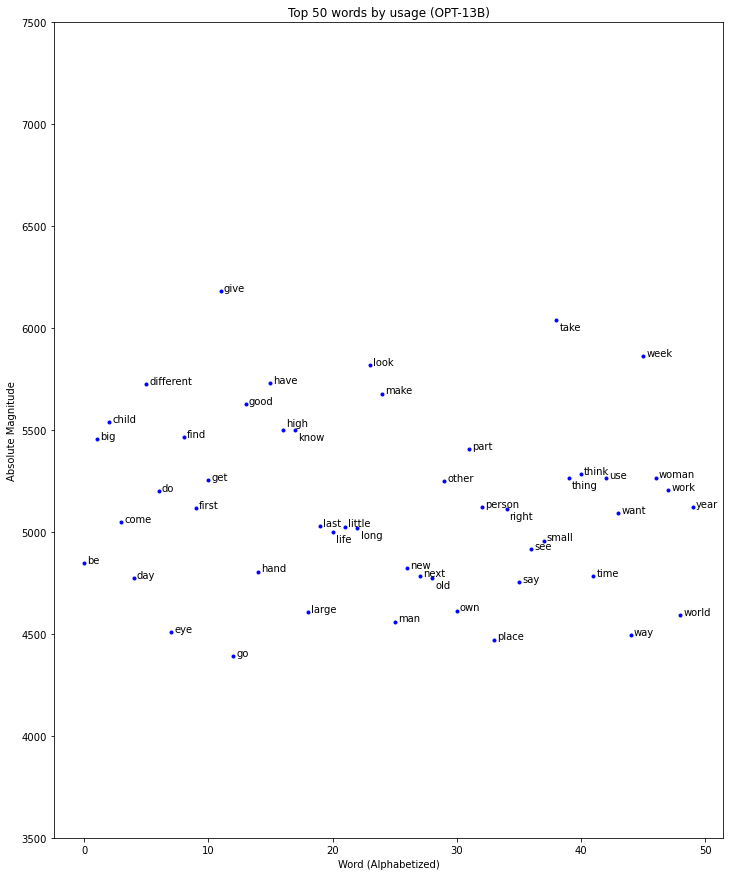

In [82]:
plt.figure(figsize=(12, 15))
plt.title('Top 50 words by usage (OPT-13B)')
plt.ylabel('Absolute Magnitude')
plt.ylim((3500, 7500))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_opt[50:], c='b', marker='.')

for i in range(50, 100):
    if i-50 in [17, 20, 22, 28, 34, 38, 39]:
        plt.annotate(X[i], (i-50 + 0.25, Y_opt[i]-50))
    elif i-50 in [16]:
        plt.annotate(X[i], (i-50+0.25, Y_opt[i]+15))
    else: plt.annotate(X[i], (i-50+0.25, Y_opt[i]))

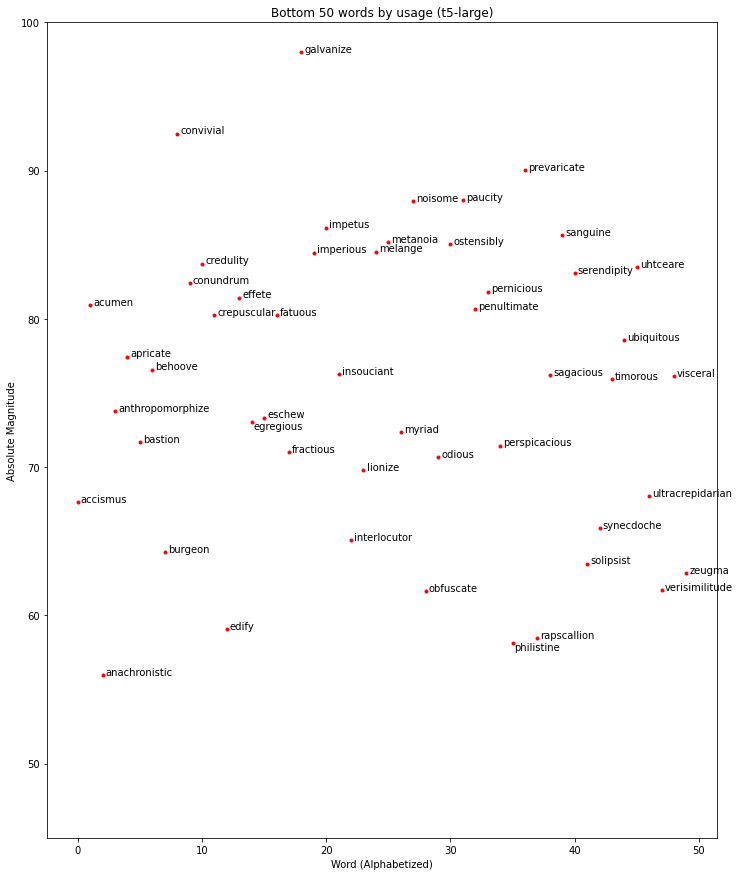

In [71]:
plt.figure(figsize=(12, 15))
plt.title('Bottom 50 words by usage (t5-large)')
plt.ylabel('Absolute Magnitude')
plt.ylim((45, 100))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_t5[:50], c='r', marker='.')

for i in range(50):
    if i in [14, 35]:
        plt.annotate(X[i], (i+0.15, Y_t5[i]-.5))
    else: plt.annotate(X[i], (i+0.25, Y_t5[i]))

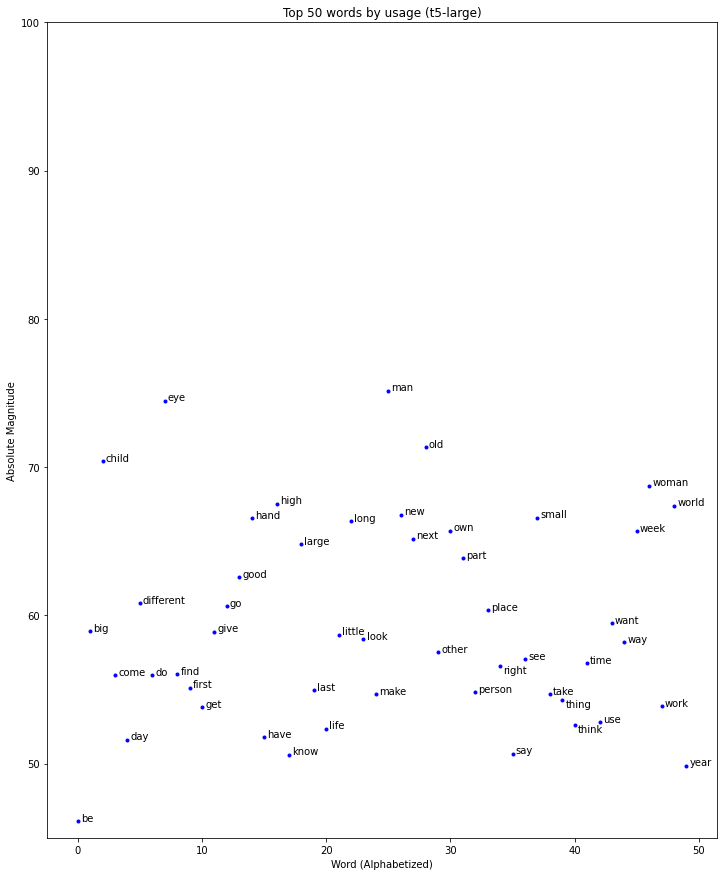

In [74]:
plt.figure(figsize=(12, 15))
plt.title('Top 50 words by usage (t5-large)')
plt.ylabel('Absolute Magnitude')
plt.ylim((45, 100))
plt.xlabel('Word (Alphabetized)')
plt.scatter(range(50), Y_t5[50:], c='b', marker='.')

for i in range(50, 100):
    if (i-50) in [34, 39, 40]:
        plt.annotate(X[i], (i-50 + 0.25, Y_t5[i]-.5))
    else: plt.annotate(X[i], (i-50 + 0.25, Y_t5[i]))

* Computing averages across dictionary
    * average magnitude
    * median magnitude

In [19]:
from statistics import median, mean

In [20]:
X_vocab = []
Y_vocab_opt = []
Y_vocab_t5 = []
for word in vocab:
    X_vocab.append(word)
    Y_vocab_opt.append(sum_complexity(word))
    Y_vocab_t5.append(sum_complexity(word, model='t5'))

In [22]:
print('|---------------------------------------------------------------------------------------------------------------|')
print(f'| Model\t\t| Mean (bot.)\t\t| Mean (top)\t\t| Median (bot.)\t\t| Median (top)\t\t|')
print(f'| OPT-13B:\t| {mean(Y_opt[:50])}\t| {mean(Y_opt[50:])}\t| {median(Y_opt[:50])}\t| {median(Y_opt[50:])}\t|')
print(f'| Full Vocab:\t|\t\t{mean(Y_vocab_opt)}\t\t|\t\t{median(Y_vocab_opt)}\t\t|')
print(f'| T5-3B:\t| {mean(Y_t5[:50])}\t| {mean(Y_t5[50:])}\t| {median(Y_t5[:50])}\t| {median(Y_t5[50:])}\t|')
print(f'| Full Vocab:\t|\t\t{mean(Y_vocab_t5)}\t\t|\t\t{median(Y_vocab_t5)}\t\t|')
print('|---------------------------------------------------------------------------------------------------------------|')

|---------------------------------------------------------------------------------------------------------------|
| Model		| Mean (bot.)		| Mean (top)		| Median (bot.)		| Median (top)		|
| OPT-13B:	| 5196.127738824398	| 5133.618387645361	| 5110.60854406665	| 5114.228084929533	|
| Full Vocab:	|		5584.864633554139		|		5485.805914451121		|
| T5-3B:	| 75.64921272322685	| 59.490047270222654	| 76.26337555302234	| 58.27756933142196	|
| Full Vocab:	|		76.90473192618569		|		78.63660070032492		|
|---------------------------------------------------------------------------------------------------------------|
